In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime
from dotenv import load_dotenv
load_dotenv()

Python-dotenv could not parse statement starting at line 16


True

In [65]:
import panel as pn
pn.extension('plotly')
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [3]:
quandl.ApiConfig.api_key = os.environ['QUANDL_API_KEY']

In [4]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [5]:
# Pull Coinbase BTC price exchange data
btc_usd_price_coinbase = get_quandl_data('BCHARTS/COINBASEUSD')

Loaded BCHARTS/COINBASEUSD from cache


In [6]:
btc_usd_price_coinbase.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2019-01-03,3890.80,3893.80,3758.07,3787.57,8840.254922,3.382343e+07,3826.069230
2019-01-04,3787.57,3849.00,3730.00,3820.82,8950.110359,3.387391e+07,3784.747665
2019-01-05,3820.82,3874.12,3775.00,3798.62,6057.934757,2.322994e+07,3834.629826
2019-01-06,3799.99,4088.00,3756.01,4040.99,9506.268897,3.763788e+07,3959.269123
2019-01-07,4040.98,4070.00,3968.79,4005.99,8876.737621,3.569372e+07,4021.040654


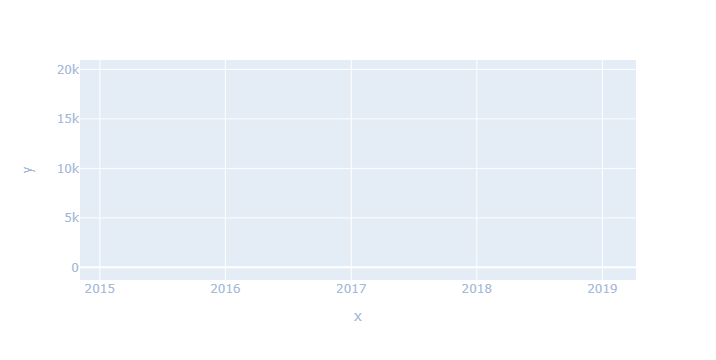

In [7]:
# Chart the BTC pricing data
btc_trace = px.scatter(x=btc_usd_price_coinbase.index, y=btc_usd_price_coinbase['Weighted Price'])
btc_trace.show()

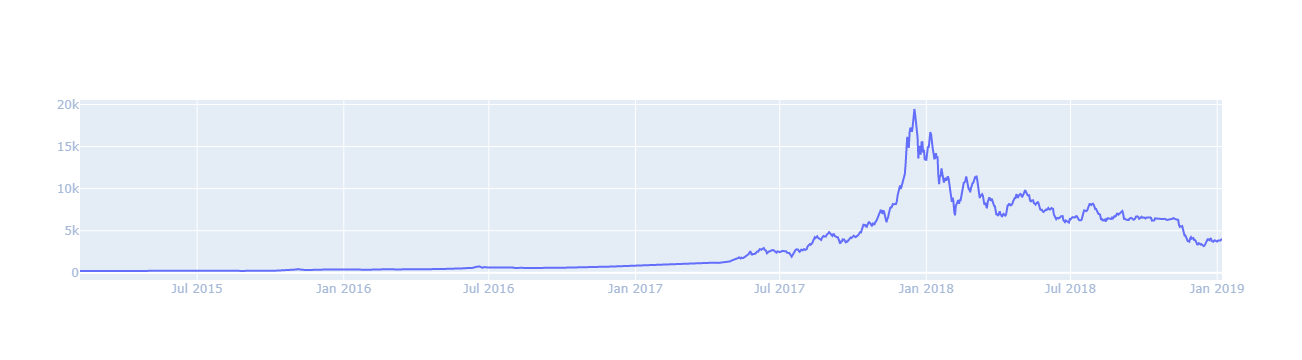

In [8]:
# Chart the BTC pricing data
btc_trace = go.Scatter(x=btc_usd_price_coinbase.index, y=btc_usd_price_coinbase['Weighted Price'])
py.iplot([btc_trace])

In [13]:
# Pull pricing data for 3 more BTC exchanges
exchanges = ['KRAKEN','BITSTAMP']

exchange_data = {}

exchange_data['COINBASE'] = btc_usd_price_coinbase

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Loaded BCHARTS/KRAKENUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache


In [14]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [15]:
#Merge the BTC price dataseries' into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [16]:
btc_usd_datasets.tail()

,COINBASE,KRAKEN,BITSTAMP
Date,,,
2021-06-16,NaN,39141.737747,39266.920444
2021-06-17,NaN,38433.468618,38449.364210
2021-06-18,NaN,36734.445103,36802.295855
2021-06-19,NaN,35743.971502,35743.751401
2021-06-20,NaN,34804.086189,34791.393581


In [25]:
# Remove "0" values
btc_usd_datasets.replace(0, np.nan, inplace=True)

In [27]:
# Calculate the average BTC price as a new column
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)

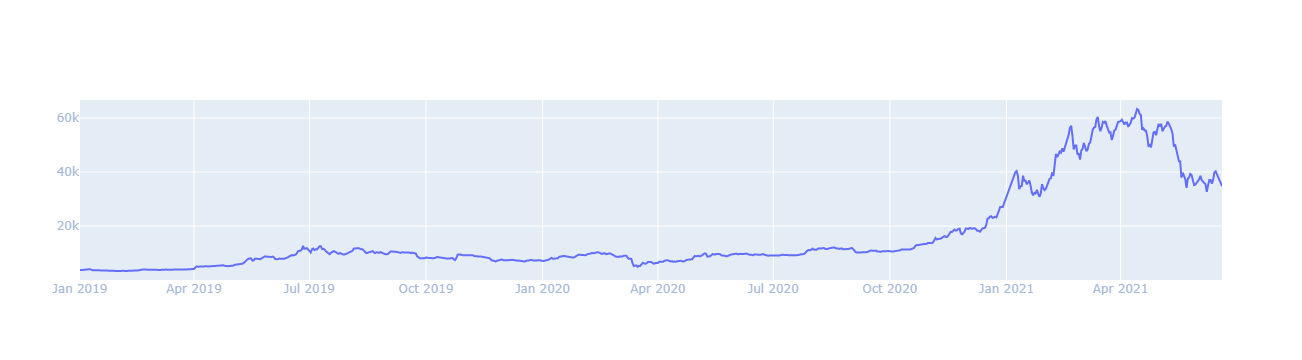

In [49]:
# Plot the average BTC price
btc_usd_datasets = btc_usd_datasets.loc['2019' : '6/30/2021']
btc_trace = go.Scatter(x=btc_usd_datasets.index, y=btc_usd_datasets['avg_btc_price_usd'])
py.iplot([btc_trace])

In [59]:
#Calculate BTC's Average Returns
returns = btc_usd_datasets['avg_btc_price_usd'].pct_change()
btc_returns =pd.DataFrame(returns) 
btc_returns.reset_index
btc_returns.dropna
btc_returns.head

<bound method NDFrame.head of             avg_btc_price_usd
Date                         
2019-01-01                NaN
2019-01-02           0.027192
2019-01-03          -0.004048
2019-01-04          -0.009362
2019-01-05           0.012790
...                       ...
2021-06-16          -0.026109
2021-06-17          -0.019460
2021-06-18          -0.043522
2021-06-19          -0.027864
2021-06-20          -0.026469

[893 rows x 1 columns]>

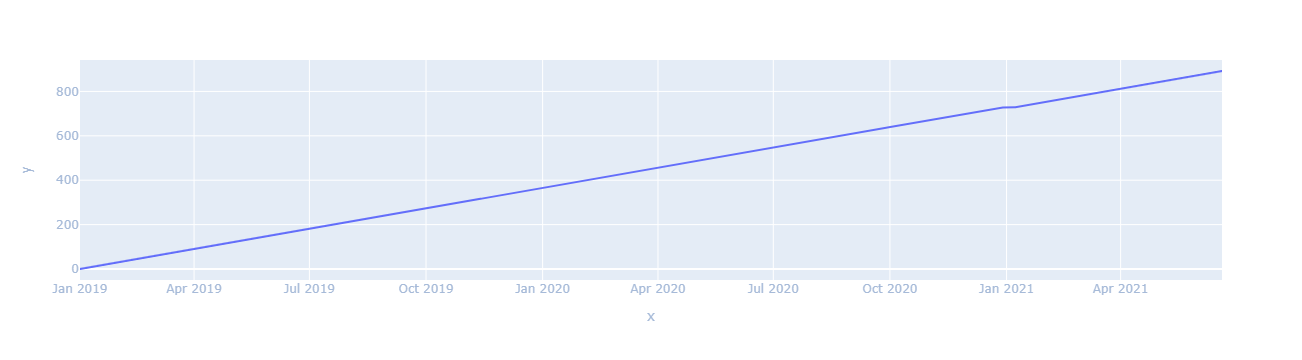

In [64]:
#Plot it
btc_returns_plot = px.line(x=btc_returns.index)
btc_returns_plot.show()
